# Compressed Sensing: Matrix Reconstitution & Completion
## Practical work 2: optimization algorithms for compressed sensing

*Badis Jaouani - M2 Statistics*
___

# Table of contents
___
0. [Preliminaries](#part1)
0. [A greed algorithm: orthogonal matching pursuit](#part2)
0. [Basis pursuit](#part3)
0. [A regularized problem: proximal methods](#part4)
0. [The exact problem: Douglas-Rachford method](#part5)
0. [Another sparsity prior](#part6)


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2

# Load nt_toolbox
import sys
sys.path.append('../tp1/')
from nt_toolbox.compressed_sensing import get_measurements, plot_image, minL2

In [2]:
import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

def answer(obj, q):
    if send(obj, q):
        print(f"Answer to Question {q} sent.")
    else:
        print("Oops… Something's wrong.")

npt_config = {
    'session_name': 'CS-Practical-2',
    'session_owner': 'maxime.sangnier@upmc.fr',
    'sender_name': input("Your name:"),
}

if send(npt_config['sender_name'], 0):
    print("Let's start!")
else:
    print("Something is wrong with sending your answers. Please ask the lecturer.")

Your name:Badis Jaouani
Something is wrong with sending your answers. Please ask the lecturer.


# 0. Preliminaries <a id="part1"></a>
___
>Let us focus on the compressed sensing problem: finding a sparse vector $x \in \mathbb R^d$ such that $y = Ax$, where the vector of measurements $y$ and the sensing matrix $A$ are given.
For this purpose, we will assess different strategies:
>- a greedy approach: orthogonal matching pursuit;
>- solving basis pursuit with an interior point method (scipy.optimize.linprog);
>- solving a regularized problem: $\operatorname{minimize}_{x \in \mathbb R ^d} \|x\|_1 + \frac{\mu}{2} \|Ax - y\|_2^2$, with proximal methods;
>- solving basis pursuit with Douglas-Rachford method;
>- introducing a new (total variation) regularization in order to improve reconstruction.

>In this practical session, we are provided with a measurement function, that returns three components.
The first two are of interest for now.

In [3]:
help(get_measurements)
y, A, T = get_measurements()

Help on function get_measurements in module nt_toolbox.compressed_sensing:

get_measurements(n=32, r_sparse=0.2, r_info=0.5)
    Measurement function.
    
    Parameters:
    - n is the image size (n x n);
    - r_sparse is the ratio of non-zero coefficients (wavelet domain) of the
    signal x to recover;
    - r_info is the ratio between the size of y and the size of x.
    
    Return y, A, T, where:
    - y is the vector of measurements;
    - A is the sensing matrix (we look for x such that y = Ax);
    - T is a total variation operator.



In [4]:
n = int(np.sqrt(A.shape[1]))
p = A.shape[0]

print(f"Image size: {n}x{n}.")
print(f"Measurement vector size: {p}")
print(f"Sensing matrix size: {A.shape[0]}x{A.shape[1]}")

Image size: 32x32.
Measurement vector size: 512
Sensing matrix size: 512x1024


>To get a first idea of the image to recover, we propose to solve the following projection problem:
$$
    \operatorname{minimize}_{x \in \mathbb R ^d}~
    \|Ax - y\|_2.
$$
Obviously, the resulting image is not a faithful approximation of the one to recover.

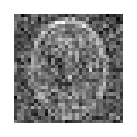

In [5]:
# L2 projection
x2 = minL2(y, A)

plot_image(x2)

# 1. A greed algorithm: orthogonal matching pursuit <a id="part2"></a>
___
>In this section, we aim at providing a a feasible point to the problem
$$
    \begin{array}{cl}
        \displaystyle{ \operatorname{minimize}_{x \in \mathbb R ^d} }
        & \displaystyle{ \|Ax - y\|_2 } \\
        \operatorname{st}
        & \displaystyle{ \|x\|_0 \le s }
    \end{array}
$$
with orthogonal matching pursuit.

>**Question 1.**
Define a function `omp(y, A, s=None, eps=None)`, that implements orthogonal matching pursuit and that:
>- returns an $s$-sparse approximation of x;
>- returns the sequence $(\|Ax_k-y\|_2)_k$;
>- terminates when $x_k$ is $s$-parse or when $\|Ax_k-y\|_2 \le \epsilon$ ($\epsilon > 0$ given).

>You can use a set object for the set of indexes: `index = set()`, `index.add(a_new_index)`, `A[:, list(index)]` for the columns of interest.

>Plot the approximation error and the solution provided by orthogonal matching pursuit.

In [6]:
# Answer
def omp(y, A, s=None, eps=None):
    # Todo
    x = np.zeros(A.shape[1])
    r = -y
    s = set()
    err = []
    for it in range(200):
        jstar = np.argmax(abs((A.T.dot(r))))
        s.add(jstar)
        x = minL2(y, A[:,list(s)])
        r = A[:,list(s)].dot(x) - y
        err.append(np.linalg.norm(r))
    # End todo
    return err, x
answer(omp, 1)

Oops… Something's wrong.


Oops… Something's wrong.


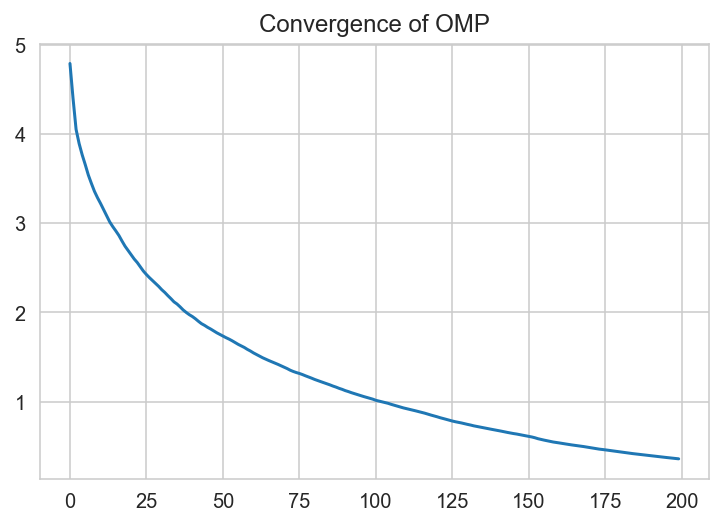

In [7]:
# Answer
err, x0 = omp(y, A)
plt.plot(err)
# End todo

plt.title('Convergence of OMP')
answer(plt, 2)

#plot_image(x0)

# 2. Basis pursuit <a id="part3"></a>
___
>We aim here at solving the basis pursuit problem:
$$
    \begin{array}{cl}
        \displaystyle{ \operatorname{minimize}_{z \in \mathbb R ^{2d}} }
        & \displaystyle{ \sum_{i=1}^{2d} z_i } \\
        \operatorname{st}
        & \left\{ \begin{array}{l}
            \displaystyle{ [A; -A]z = y } \\
            \displaystyle{ z_i \ge 0, \forall i \in [2d] }
        \end{array} \right.
    \end{array}
$$
with an off-the-shelf simplex method (scipy.optimize.linprog).

>**Question 1.**
Read the documentation of `linprog` and use it to solve basis pursuit.
For this purpose, you can define a function `basispursuit(y, A)` returning a solution $z$ to the previous problem.
What can you conclude?

In [8]:
import scipy
?scipy.optimize.linprog

Oops… Something's wrong.


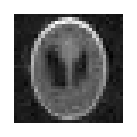

In [9]:
# Answer
def basispursuit(y, A):
    # Todo
    p = 2*A.shape[1]
    mat = np.c_[A,-A]
    x = scipy.optimize.linprog(c = np.ones(p), 
                               A_eq = mat, b_eq = y, 
                               bounds = (0,None),
                               #method = 'simplex'
                              )
    x_sol = x['x'][:p//2] - x['x'][p//2:]
    return x_sol
    # End todo

answer(basispursuit, 3)

xbp = basispursuit(y, A)
plot_image(xbp)

>**Question 2.**
To go furher, we propose to use a barrier method for large scale optimization.
For this purpose, install `cxvopt` and use [cvxopt.solvers.lp](http://cvxopt.org/userguide/coneproghtml#linear-programming).
You can define a function `barrier(y, A)` returning a solution $z$ to the previous problem.

Oops… Something's wrong.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.8858e-16 -5.6174e-16  5e+03  1e+02  3e-17  1e+00
 1:  1.3703e+01  1.3757e+01  8e+02  2e+01  2e-16  2e-01
 2:  3.9856e+01  3.9884e+01  3e+02  6e+00  2e-16  9e-02
 3:  5.8514e+01  5.8525e+01  1e+02  2e+00  5e-16  3e-02
 4:  6.7992e+01  6.7997e+01  4e+01  8e-01  4e-16  1e-02
 5:  7.2470e+01  7.2472e+01  2e+01  3e-01  4e-16  5e-03
 6:  7.3922e+01  7.3923e+01  8e+00  2e-01  5e-16  3e-03
 7:  7.4674e+01  7.4675e+01  4e+00  1e-01  5e-16  2e-03
 8:  7.5081e+01  7.5082e+01  2e+00  5e-02  4e-16  1e-03
 9:  7.5451e+01  7.5452e+01  8e-01  2e-02  5e-16  4e-04
10:  7.5548e+01  7.5548e+01  4e-01  8e-03  5e-16  2e-04
11:  7.5590e+01  7.5590e+01  2e-01  4e-03  5e-16  9e-05
12:  7.5621e+01  7.5621e+01  6e-02  1e-03  5e-16  3e-05
13:  7.5631e+01  7.5631e+01  2e-02  5e-04  5e-16  1e-05
14:  7.5634e+01  7.5634e+01  8e-03  2e-04  5e-16  4e-06
15:  7.5635e+01  7.5635e+01  4e-03  9e-05  4e-16  2e-06
16:  7.5636e+01  7.5636e+

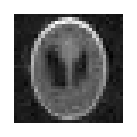

In [10]:
# Answer
from cvxopt import matrix, solvers

def barrier(y, A):
    # Todo
    p = 2*A.shape[1]
    mat = np.c_[A,-A]
    x = solvers.lp(c = matrix(np.ones(p)),
                   G = matrix(-np.eye(p)),
                   h = matrix(np.zeros(p)),
                   A = matrix(mat),
                   b = matrix(y)
                  )
    return np.array(x['x'][:p//2] - x['x'][p//2:])
    # End todo


answer(barrier, 4)

xbp = barrier(y, A)
plot_image(xbp)

# 3. A regularized problem: proximal methods <a id="part4"></a>
___
>In this section, we decide to approximate the linear constraint with a regularization.
Therefore, we aim at solving:
$$
    \operatorname{minimize}_{x \in \mathbb R ^d}
    \|x\|_1 + \frac{\mu}{2} \|Ax - y\|_2^2,
$$
where $\mu > 0$.

>**Question 1.**
Show that:
$$
    [\operatorname{prox}_{\gamma \|\cdot\|_1} (x) ]_i = \max \left(0, 1- \frac{\gamma}{|x_i|} \right) x_i.
$$

>Implement this function with signature `proxL1(x, gamma)`.

**Answer:**
…

In [11]:
# Answer
def proxL1(x, gamma):
    # Todo
    prox = (1 - gamma / np.abs(x)) * ((1 - gamma / np.abs(x)) >= 0)
    prox = prox * x
    return prox
    # End todo

answer(proxL1, 5)

Oops… Something's wrong.


>**Question 2.**
Define a function `ista(y, A, mu=1., n_it=100)`, that:
>- performs a proximal gradient descent with fixed step size;
>- terminates after n_it iterations;
>- returns an approximate solution $x$ and the sequence of objective values $(\|x_k\|_1 + \frac{\mu}{2} \|Ax_k - y\|_2^2)_k$.

>Run this function to recover the original image.
Plot the image, the objective function and compute the error $\|Ax - y\|_2$.

In [12]:
# Answer
def ista(y, A, mu=1., n_it=100):
    # Todo
    p = A.shape[1]
    x = np.random.randn(p)
    obj, err = [], []
    Q = A.T.dot(A)
    lambda_max = np.linalg.eigvalsh(Q).max()
    gamma = 1/(mu * lambda_max)
    
    for it in range(n_it):
        x1 = x - gamma * mu * (A.T.dot(A.dot(x) - y))
        x = proxL1(x1, gamma)
        obj.append(np.sum(np.abs(x)) + mu/2 * np.linalg.norm(A.dot(x) - y)**2)
        err.append(np.linalg.norm(A.dot(x) - y))
    # End todo
    return x, obj, err
answer(ista, 6)

Oops… Something's wrong.


Oops… Something's wrong.


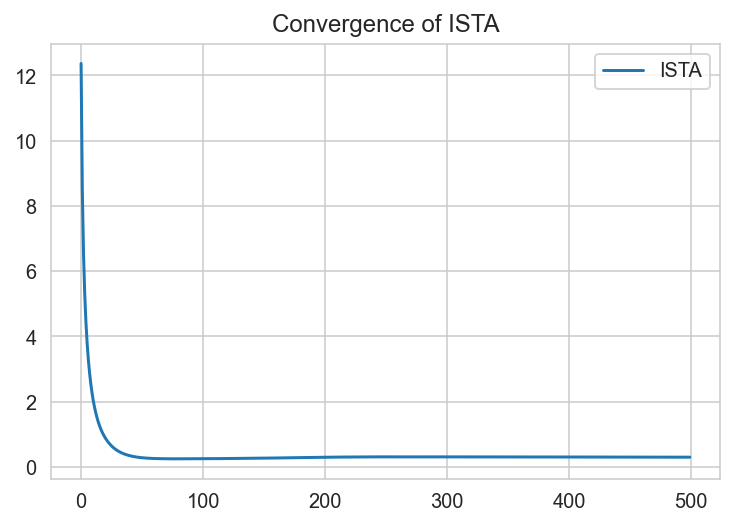

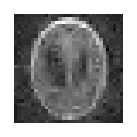

In [13]:
# Answer
mu = 1e2
it = 500

# Todo
x_sol, obj, err = ista(y, A, mu = mu, n_it = it)
# End todo

plt.plot(range(it), err ,label = 'ISTA')
plt.title('Convergence of ISTA')
plt.legend()
answer(plt, 7)

plot_image(x_sol)

>**Question 3.**
Do the same with an accelerated proximal method.
The function can be called `fista`.

In [14]:
# Answer
def fista(y, A, mu=1., n_it=100):
    # Todo
    p = A.shape[1]
    Q = A.T.dot(A)
    gamma = 1 / (mu * np.linalg.eigvalsh(Q).max())
    lamda_k, lamda_k1 = 0, 0
    x_k, z = np.random.randn(p), np.random.randn(p)
    x_k1 = x_k
    err = []
    
    for it in range(n_it):
        x_k1 = proxL1(z - gamma * mu * (A.T.dot(A.dot(z) - y)), gamma)
        lamda_k1 = (1 + np.sqrt(1 + 4 * lamda_k**2)) / 2
        z = x_k1 + (lamda_k - 1)/lamda_k1 * (x_k1 - x_k)
        lamda_k = lamda_k1
        x_k = x_k1
        err.append(np.linalg.norm(A.dot(x_k) - y))
    return x_k, err
    # End todo

answer(fista, 8)

Oops… Something's wrong.


Oops… Something's wrong.


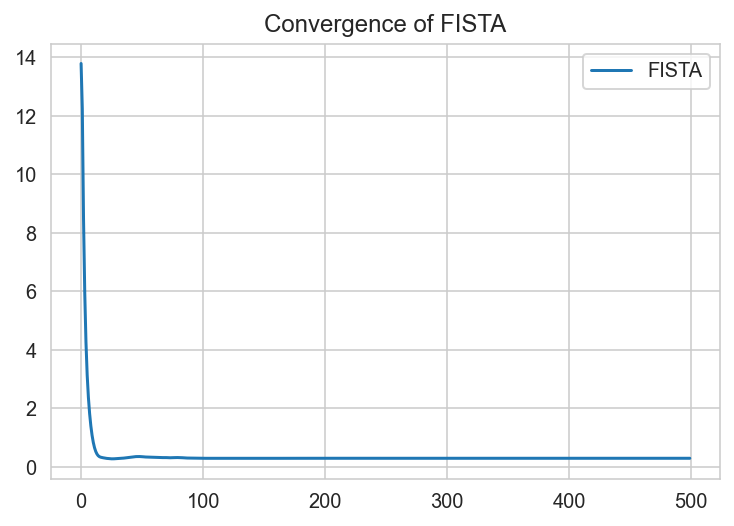

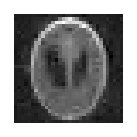

In [15]:
# Answer
mu = 1e2
it = 500
# Todo
x_sol_fista, err_fista = fista(y, A, mu = mu, n_it =it)
# End todo

plt.plot(range(it), err_fista, label = 'FISTA')
plt.legend()

plt.title('Convergence of FISTA')
answer(plt, 9)

plot_image(x_sol_fista)

>**Question 4.**
Compare the behavior of the objective function for ISTA and FISTA.
Compare with theoretical convergence bounds.

Oops… Something's wrong.


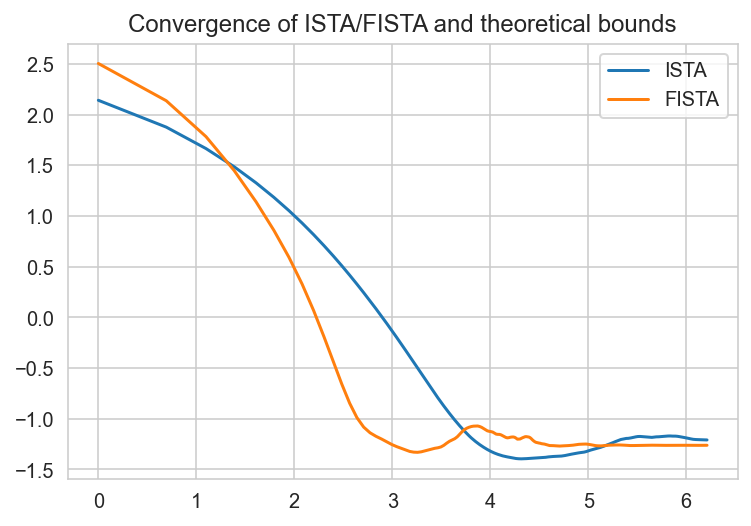

In [16]:
# Answer
# Todo
plt.plot(np.log(range(it)), np.log(err), label = 'ISTA')
plt.plot(np.log(range(it)), np.log(err_fista), label = 'FISTA')
plt.legend()
# End todo

plt.title('Convergence of ISTA/FISTA and theoretical bounds')
answer(plt, 10)

# 4. The exact problem: Douglas-Rachford method <a id="part5"></a>
___
>Conversely to the approximation in the previous section, we aim now at solving the original problem involved in compressed sensing:
$$
    \operatorname{minimize}_{x \in \mathbb R ^d}
    \|x\|_1 + \chi_{\mathcal A}(x),
$$
where $\mathcal A = \{x \in \mathbb R^d : Ax = y\}$.

>**Question 1.**
Show that $\operatorname{prox}_{\chi_{\mathcal A}}(x) = (I - A^\top(AA^\top)^{-1}A)x + A^\top(AA^\top)^{-1}y$.

**Answer:**
…

>**Question 2.**
Define a function `DRmethod(y, A, n_it=100, version=1)` that implements the Douglas-Rachford method with $f = \|\cdot\|_1$ and $g = \chi_{\mathcal A}$ (first version), and conversely with $f = \chi_{\mathcal A}$ and $g = \|\cdot\|_1$ (second version).
This function has to return an approximate solution and the sequence $(\|x_k\|_1)_k$.

>Compare both versions based on the recovered image, the behavior of the objective value and the error $\|Ax - y\|_2$.
Which one is preferable?

In [17]:
# Proximal operator
def proxA(x):
    p = A.shape[1]
    I = np.eye(p)
    prox = (I - A.T.dot(np.linalg.inv(A.dot(A.T))).dot(A)).dot(x) + A.T.dot(np.linalg.inv(A.dot(A.T))).dot(y)
    return prox

In [18]:
# Answer
def DRmethod(y, A, n_it=100, version=1):
    # Todo
    p = A.shape[1]
    z, x = np.random.randn(p), np.random.randn(p)
    mu, gamma = 1, 1
    norm = []
    
    if version == 1:
        for it in range(n_it):
            x = proxA(z)
            z = z + mu * (proxL1(2*x - z, gamma) - x)
            norm.append(np.sum(np.abs(x)))
        err = np.linalg.norm(A.dot(x) - y)
        return x, norm, err
    
    
    
    elif version == 2:
        for it in range(n_it):
            x = proxL1(z, gamma)
            z = z + mu * (proxA(2*x - z) - x)
            norm.append(np.sum(np.abs(x)))
        err = np.linalg.norm(A.dot(x) - y)
        return x, norm, err
    # End todo

#answer(DRmethod, 11)

err V1 = 3.666857584890558e-14
err V2 = 0.03211475027735202


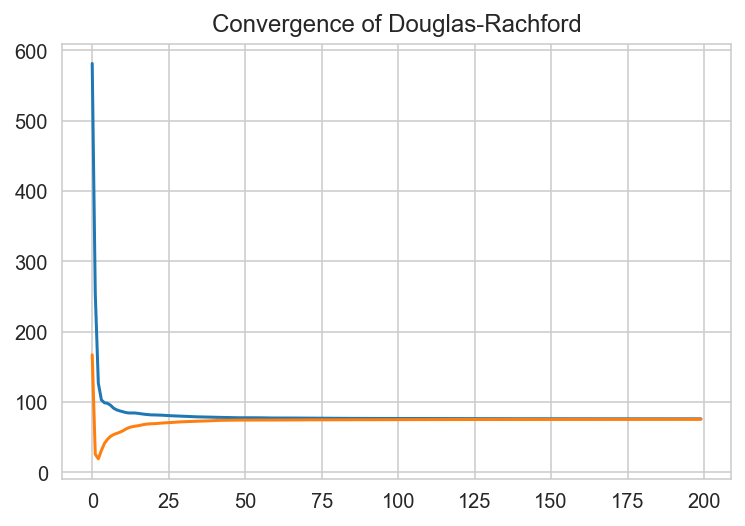

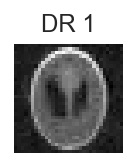

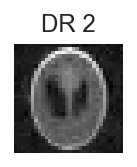

In [19]:
# Answer
n_it = 200

# Todo
x_v1, norm_v1, err_v1 = DRmethod(y, A, n_it=n_it, version=1)
x_v2, norm_v2, err_v2 = DRmethod(y, A, n_it=n_it, version=2)

print('err V1 = {}'. format(err_v1))
print('err V2 = {}'. format(err_v2))

plt.plot(range(n_it), norm_v1, label = 'V1')
plt.plot(range(n_it), norm_v2, label = 'V2')
# End todo

plt.title('Convergence of Douglas-Rachford')
#answer(plt, 12)

plot_image(x_v1)
plt.title("DR 1")
plot_image(x_v2)
plt.title("DR 2");

# 5. Another sparsity prior <a id="part6"></a>
___
>In order to improve image reconstruction, we propose to regularize with a total variation operator $T$.
The problem to minimize becomes:
$$
    \operatorname{minimize}_{x \in \mathbb R ^d}~
    \|Tx\|_1 + \frac{\mu}{2} \|Ax-y\|_2^2.
$$

>This problem can be rewritten in:
$$
    \begin{array}{cl}
        \displaystyle{ \operatorname{minimize}_{z, x} }
        & \displaystyle{ \|z\|_1 + \frac{\mu}{2} \|Ax-y\|_2^2 } \\
        \operatorname{st}
        & \displaystyle{ Tx = z. }
    \end{array}
$$

>We aim at solving this problem with ADMM.


>**Question 1.**
Show that minimizing the augmented Lagrangian with respect to $z$ boils down to:
$$
    z_{k+1} = \operatorname{prox}_{\frac 1 \gamma \|\cdot\|_1}(Tx_k + \frac 1 \gamma \nu_k).
$$

**Answer:**
…

>**Question 2.**
Show that minimizing the augmented Lagrangian with respect to $x$ boils down to:
$$
    x_{k+1} = (\mu A^\top A + \gamma T^\top T)^{-1}(\mu A^\top y + T^\top(\gamma z_{k+1} - \nu_k)).
$$

**Answer:**
…

>**Question 3.**
Define a function `ADMM(y, A, T, mu=1., n_it=100, gamma=1.)` for solving the problem.
This function has to return an approximate solution and the sequence of objective values.

>Is the result different from solutions obtained with proximal methods?

In [20]:
# Answer
def ADMM(y, A, T, mu=1., n_it=100, gamma=1.):
    # Initialization
    d, p  = A.shape[1], T.shape[1]
    x = np.random.randn(d)
    z = np.random.randn(T.shape[0])
    nu = np.random.randn(T.shape[0])
    obj = []
    
    # Update
    for it in range(n_it):
        z = proxL1(T.dot(x) + nu/gamma, gamma)
        x = np.linalg.inv(mu * A.T.dot(A) + gamma * T.T.dot(T)).dot(mu * A.T.dot(y) + T.T.dot(gamma * z - nu))
        nu = nu + gamma * (T.dot(x) - z)
        obj.append(np.sum(np.abs(T.dot(x))) + mu/2 * np.linalg.norm(A.dot(x) - y)**2)
    err = np.linalg.norm(A.dot(x) - y)

    return x, obj, err

In [21]:
# Answer
x_sol, obj, err = ADMM(y, A, T, mu=3e2, n_it=n_it, gamma=.1)

MSE: 0.003876498886726122


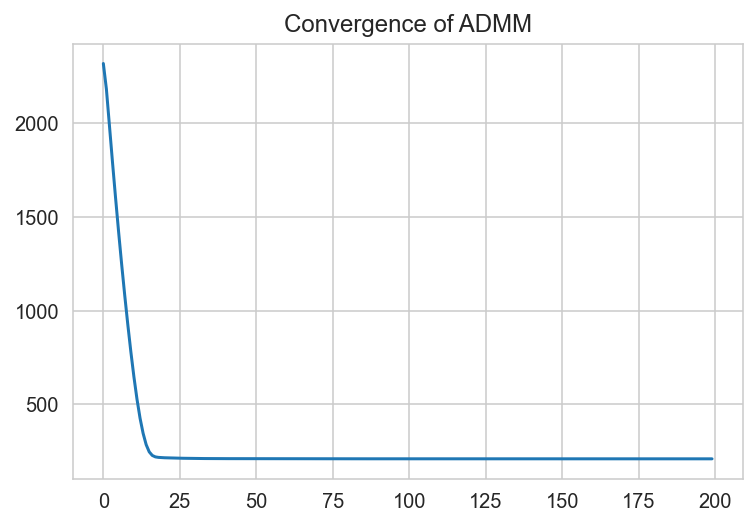

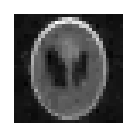

In [22]:
print('MSE: {}'.format(err))
plt.plot(range(n_it), obj)
plt.title('Convergence of ADMM')

plot_image(x_sol)